In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Network
## Lecture 22
- multi-class - Fashion MNIST dataset (all 60000 images)
- With Regularization


In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report


import tensorflow as tf

from utils.helper import fn_plot_confusion_matrix, fn_plot_tf_hist

2024-05-28 12:51:31.410792: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 12:51:31.410833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 12:51:31.411928: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 12:51:31.417563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 12:51:32.212815: W tensorflow/compiler/tf2

In [3]:
# Some basic parameters
inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'fashion_MNIST' # location of the images
modelDir = '../models'
altName = 'tf_cnn'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)

EPOCHS = 200 # number of cycles to run
ALPHA = 0.001 # learning rate
BATCH_SIZE = 32

PATIENCE = 20
LR_PATIENCE  = 10
LR_FACTOR = 0.1

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-05-28 12:51:32.995877: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 12:51:33.031309: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 12:51:33.031565: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [5]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [6]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',
               1:'Trouser',
               2:'Pullover',
               3:'Dress',
               4:'Coat',
               5:'Sandal', 
               6: 'Shirt',
               7: 'Sneaker', 
               8:'Bag', 
               9: 'Ankle boot'}

## Prepare data

In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

In [9]:
def split_feature_label(row):
    feature = tf.reshape(row[1:], [28, 28, 1])
    label = row[0]
    return feature, label

In [10]:
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)
train_ds = tmp_ds.map(split_feature_label)
train_ds = train_ds.batch(BATCH_SIZE)

2024-05-28 12:51:35.041659: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 12:51:35.041919: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 12:51:35.042099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Whats in the data?

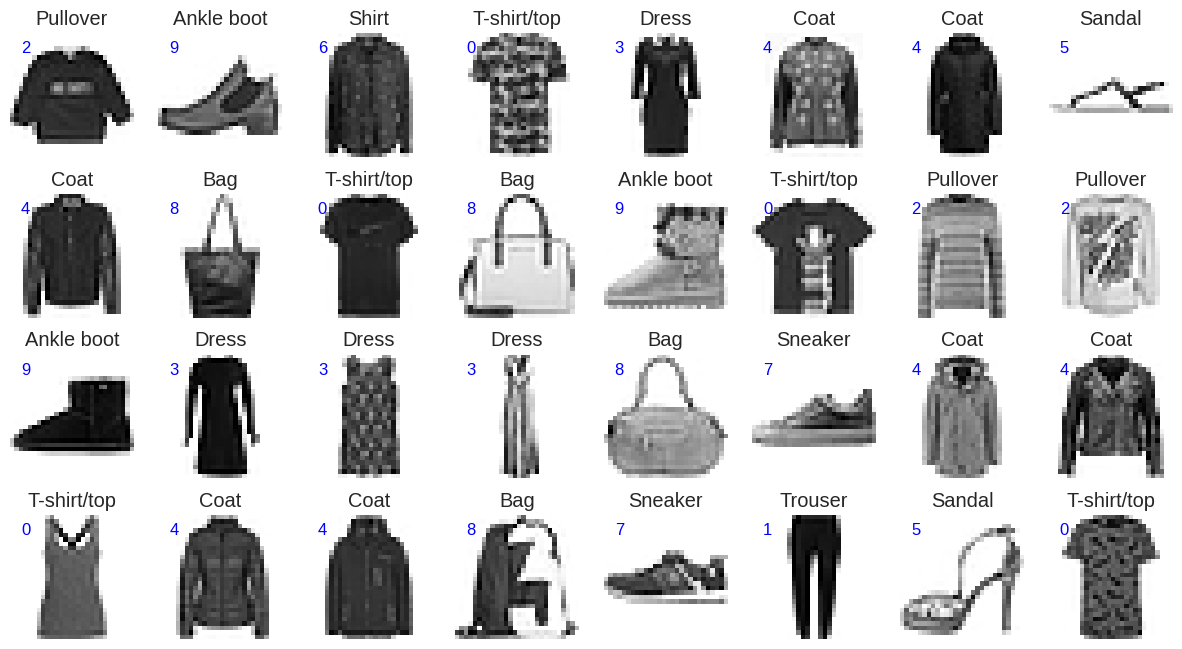

In [11]:
# Sample data plot
fig = plt.figure(figsize=(15, 8))  # figure size in inches

for images, labels in train_ds.take(1):
    
    for i in range(BATCH_SIZE):

        plt.subplot(4, int(BATCH_SIZE//4), i+1)
    
        plt.imshow(images[i].numpy().astype('uint16'), 
                   cmap=plt.cm.binary, 
                   interpolation='nearest') # show image on the axis
    
        plt.title(class_names[labels[i].numpy()])   # add number (class) of the image
    
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)   # add name of the image
        
        plt.axis('off')

plt.show()

In [12]:
tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)
test_ds = tmp_ds.map(split_feature_label)
test_ds = test_ds.batch(BATCH_SIZE)

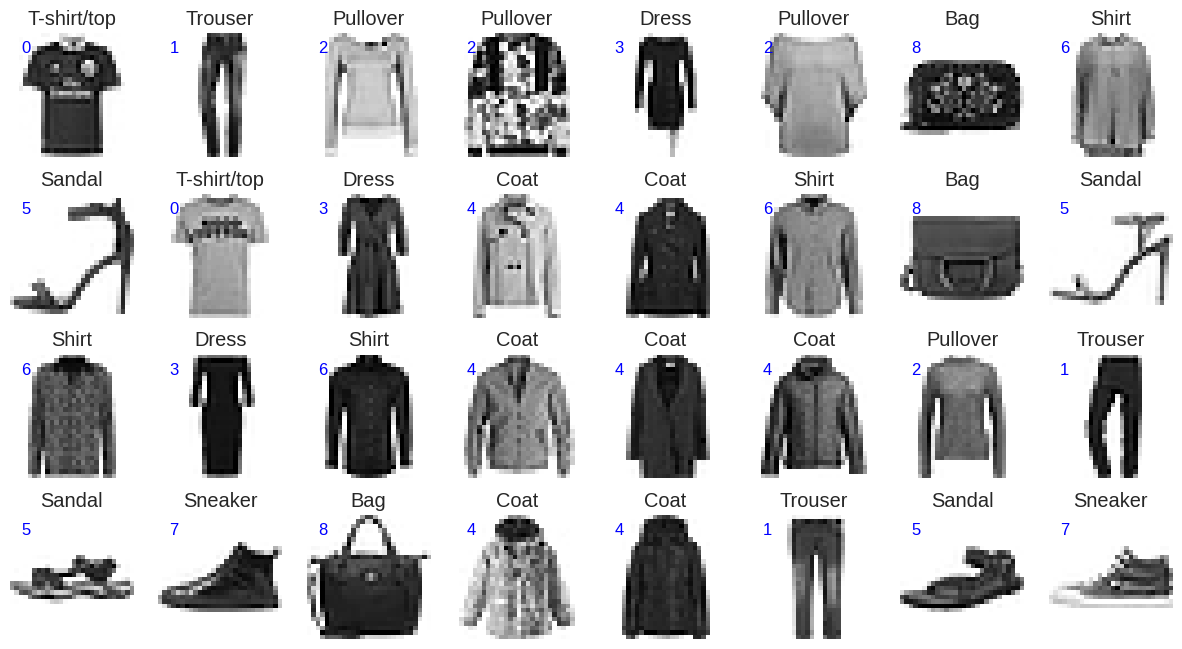

In [13]:
# Sample data plot
fig = plt.figure(figsize=(15, 8))  # figure size in inches

for images, labels in test_ds.take(1):
    
    for i in range(BATCH_SIZE):

        plt.subplot(4, int(BATCH_SIZE//4), i+1)
    
        plt.imshow(images[i].numpy().astype('uint16'), 
                   cmap=plt.cm.binary, 
                   interpolation='nearest') # show image on the axis
    
        plt.title(class_names[labels[i].numpy()])   # add number (class) of the image
    
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)   # add name of the image
        
        plt.axis('off')

plt.show()

In [14]:
## Optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Define Model

In [21]:
reg_lambda = 0.005

knl_reg = tf.keras.regularizers.L2(reg_lambda)

model = tf.keras.Sequential()

# Pre-processing
model.add(tf.keras.layers.Rescaling(1./255.))

###------
### Set 1
###------
model.add(tf.keras.layers.Conv2D(32, 3,
    padding='same',
    activation='relu',
    kernel_regularizer=knl_reg,
    input_shape = (28,28,1)))   # 28 x 28 x 32

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2))) # 14 x 14 x 32

###------
### Set 2
###------
model.add(tf.keras.layers.Conv2D(64, 3,
    kernel_regularizer=knl_reg,
    activation='relu'))   # 12 x 12 x 64

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2))) # 6 x 6 x 64

###------
### Set 3
###------
model.add(tf.keras.layers.Conv2D(128, 3,
    kernel_regularizer=knl_reg,
    activation='relu'))   # 4 x 4 x 128

### Head

In [22]:
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64, 
                                activation= 'relu',
                                kernel_regularizer=knl_reg))

model.add(tf.keras.layers.Dense(10))


In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
checkpoint_filepath = os.path.join(modelDir, subDir, 'weights_fifa')

model_ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = 'val_loss',
    mode = 'auto',
    verbose=2,
    save_best_only = True)


es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    verbose=2,
    restore_best_weights=True)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_lr=0.00001)

#log_dir = os.path.join(logDir, 'fit')
#tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [25]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks = [model_ckpt_callback, es_callback, lr_callback],
                    validation_data=test_ds)

Epoch 1/100


2024-05-28 12:51:39.961233: I external/local_xla/xla/service/service.cc:168] XLA service 0x73ceeca953a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-28 12:51:39.961257: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-28 12:51:39.965946: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716880900.040159   13206 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1861/1875 [============================>.] - ETA: 0s - loss: 0.8061 - accuracy: 0.7992
Epoch 1: val_loss improved from inf to 0.60621, saving model to ../models/fashion_MNIST/weights_fifa
1875/1875 [==============================] - 7s 3ms/step - loss: 0.8051 - accuracy: 0.7992 - val_loss: 0.6062 - val_accuracy: 0.8544 - lr: 0.0010
Epoch 2/100
1875/1875 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.8442
Epoch 2: val_loss improved from 0.60621 to 0.55815, saving model to ../models/fashion_MNIST/weights_fifa
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6036 - accuracy: 0.8442 - val_loss: 0.5581 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 3/100
1858/1875 [============================>.] - ETA: 0s - loss: 0.5613 - accuracy: 0.8543
Epoch 3: val_loss improved from 0.55815 to 0.52845, saving model to ../models/fashion_MNIST/weights_fifa
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5614 - accuracy: 0.8541 - val_loss: 0.5284 - 

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         7

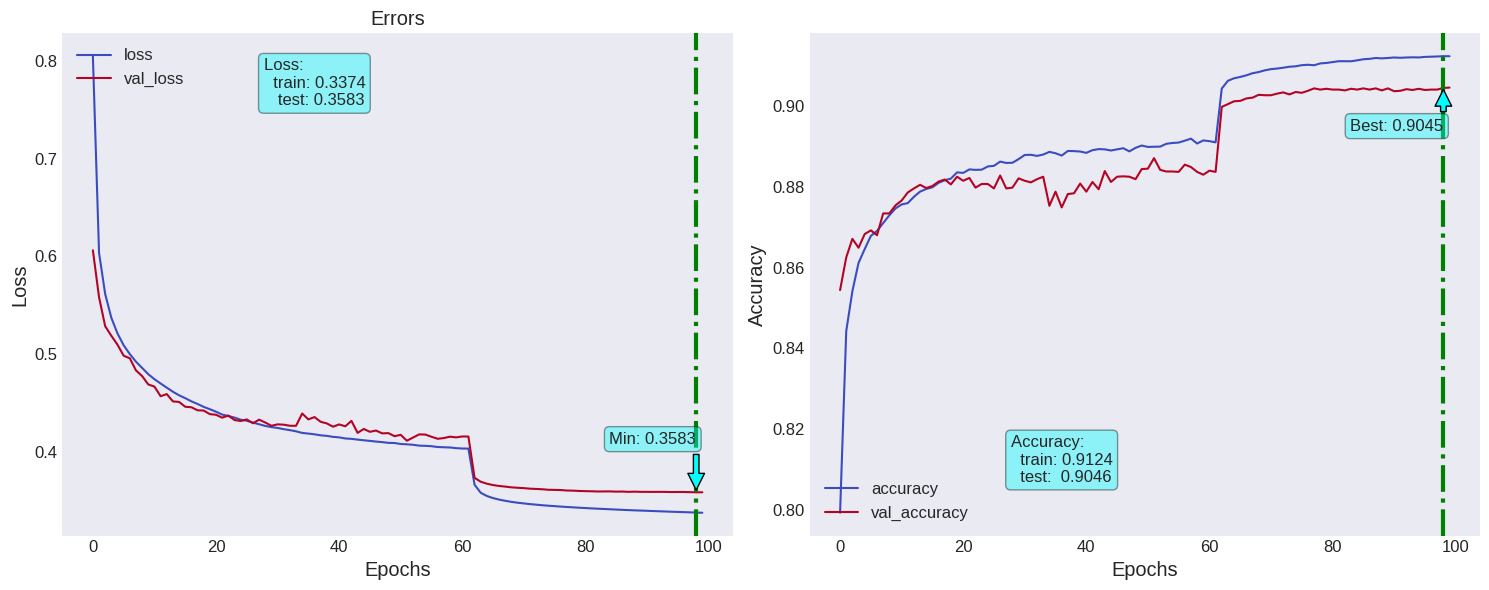

In [27]:
fn_plot_tf_hist(pd.DataFrame(history.history))